
# Stock Price Prediction - Complete ML Project

In [6]:
# Step 1: Import Required Libraries
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
# Step 2: Load and Initial Data Exploration
# ========================================

print(" Loading dataset...")

#  Upload your CSV file 
df = pd.read_csv('/content/NSE-Tata-Global-Beverages-Limited.csv')  # Update this path with your actual file name

# Check the actual column names in your dataset
print(" Actual column names in your dataset:")
print(list(df.columns))

# Clean column names (remove any extra spaces)
df.columns = df.columns.str.strip()


column_mapping = {}

# Check and map each column
if 'Date' in df.columns:
    column_mapping['Date'] = 'Date'
elif any('date' in col.lower() for col in df.columns):
    date_col = [col for col in df.columns if 'date' in col.lower()][0]
    column_mapping[date_col] = 'Date'

# Map numeric columns based on your actual column names
for col in df.columns:
    col_lower = col.lower().strip()
    if col_lower in ['open']:
        column_mapping[col] = 'Open'
    elif col_lower in ['high']:
        column_mapping[col] = 'High'
    elif col_lower in ['low']:
        column_mapping[col] = 'Low'
    elif col_lower in ['close']:
        column_mapping[col] = 'Close'
    elif col_lower in ['last']:
        column_mapping[col] = 'Last'
    elif 'total' in col_lower and 'trd' in col_lower:
        column_mapping[col] = 'Total_Trd'
    elif 'turnover' in col_lower and 'lac' in col_lower:
        column_mapping[col] = 'Turnover_Lacs'

print(f"\nColumn mapping identified: {column_mapping}")

# Rename columns if mapping exists
if column_mapping:
    df = df.rename(columns=column_mapping)
    print(" Columns renamed successfully")


print(f"\n Final column names: {list(df.columns)}")

# Handle the case where column names might be slightly different

actual_cols = df.columns.tolist()

# Try to identify key columns even if names are different
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f" Numeric columns found: {numeric_cols}")

# If we have fewer than expected columns, work with what we have
if len(numeric_cols) < 5:
    print(" Warning: Limited numeric columns found. Adjusting analysis accordingly.")

print(" Dataset Shape:", df.shape)
print("\n Dataset Info:")
print(df.info())
print("\n First 5 rows:")
print(df.head())


 Loading dataset...
 Actual column names in your dataset:
['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity', 'Turnover (Lacs)']

Column mapping identified: {'Date': 'Date', 'Open': 'Open', 'High': 'High', 'Low': 'Low', 'Last': 'Last', 'Close': 'Close', 'Turnover (Lacs)': 'Turnover_Lacs'}
 Columns renamed successfully

 Final column names: ['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity', 'Turnover_Lacs']
 Numeric columns found: ['Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity', 'Turnover_Lacs']
 Dataset Shape: (1235, 8)

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1235 non-null   object 
 1   Open                  1235 non-null   float64
 2   High                  1235 non-null   float64
 3   Low                   1235 non-nu

In [10]:
# Step 3: Data Cleaning and Preprocessing
# ======================================
print("\n" + "="*50)
print(" DATA CLEANING & PREPROCESSING")
print("="*50)

# Check for missing values
print(" Missing Values:")
print(df.isnull().sum())

# Handle date column
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

# Remove any rows with missing critical values
df = df.dropna()

# Basic statistics
print("\n Basic Statistics:")
print(df.describe())


 DATA CLEANING & PREPROCESSING
 Missing Values:
Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover_Lacs           0
dtype: int64

 Basic Statistics:
                                Date         Open         High          Low  \
count                           1235  1235.000000  1235.000000  1235.000000   
mean   2016-04-08 15:39:47.368421120   168.954858   171.429069   166.402308   
min              2013-10-08 00:00:00   103.000000   104.600000   100.000000   
25%              2015-01-10 12:00:00   137.550000   138.925000   135.250000   
50%              2016-04-11 00:00:00   151.500000   153.250000   149.500000   
75%              2017-07-10 12:00:00   169.000000   172.325000   166.700000   
max              2018-10-08 00:00:00   327.700000   328.750000   321.650000   
std                              NaN    51.499145    52.436761    50.542919   

In [12]:
# Step 4: Feature Engineering
# ==========================
print("\n" + "="*50)
print(" FEATURE ENGINEERING")
print("="*50)

# Create technical indicators and features
def create_features(df):
    """Create technical analysis features based on available columns"""
    df = df.copy()

    # Get available numeric columns
    available_cols = df.columns.tolist()

    # Basic price-based features (adapt to available columns)
    if 'High' in available_cols and 'Low' in available_cols:
        df['Price_Range'] = df['High'] - df['Low']
        df['Mid_Price'] = (df['High'] + df['Low']) / 2

        if 'Close' in available_cols:
            df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
            df['High_Low_Ratio'] = df['High'] / (df['Low'] + 0.001)  # Avoid division by zero

    # Daily return calculation (adapt to available price columns)
    if 'Close' in available_cols and 'Open' in available_cols:
        df['Daily_Return'] = (df['Close'] - df['Open']) / (df['Open'] + 0.001) * 100
        df['Price_Change'] = df['Close'] - df['Open']
    elif 'Close' in available_cols and 'Last' in available_cols:
        df['Daily_Return'] = (df['Close'] - df['Last']) / (df['Last'] + 0.001) * 100
        df['Price_Change'] = df['Close'] - df['Last']

    # Volume-based features (check for volume columns)
    volume_cols = [col for col in available_cols if any(keyword in col.lower()
                   for keyword in ['total', 'trd', 'volume', 'turnover'])]

    if len(volume_cols) >= 1:
        vol_col = volume_cols[0]
        if 'Daily_Return' in df.columns:
            df['Volume_Price_Trend'] = df[vol_col] * df['Daily_Return']

        if len(volume_cols) >= 2:
            vol_col2 = volume_cols[1]
            df['Volume_Ratio'] = df[vol_col] / (df[vol_col2] + 1)

    # Moving averages (if we have a Close price column)
    price_col = None
    if 'Close' in available_cols:
        price_col = 'Close'
    elif 'Last' in available_cols:
        price_col = 'Last'
    elif len([col for col in available_cols if any(p in col.lower() for p in ['price', 'close'])]) > 0:
        price_col = [col for col in available_cols if any(p in col.lower() for p in ['price', 'close'])][0]

    if price_col and len(df) >= 5:
        df['MA_5'] = df[price_col].rolling(window=5, min_periods=1).mean()
        df['MA_10'] = df[price_col].rolling(window=min(10, len(df)), min_periods=1).mean()
        df['Price_vs_MA5'] = df[price_col] - df['MA_5']
        df['Price_vs_MA10'] = df[price_col] - df['MA_10']

        # Volatility measures
        if 'Daily_Return' in df.columns:
            df['Volatility_5'] = df['Daily_Return'].rolling(window=5, min_periods=1).std()

        # Lag features
        df['Prev_Price'] = df[price_col].shift(1)
        df['Price_vs_Prev'] = df[price_col] - df['Prev_Price']

        # Price momentum
        df['Price_Momentum_3'] = df[price_col] - df[price_col].shift(3)
        df['Price_Momentum_5'] = df[price_col] - df[price_col].shift(5)

    # Time-based features (if Date column exists)
    if 'Date' in df.columns:
        try:
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df['Day_of_Week'] = df['Date'].dt.dayofweek
            df['Month'] = df['Date'].dt.month
            df['Quarter'] = df['Date'].dt.quarter
            df['Year'] = df['Date'].dt.year
        except:
            print(" Could not process Date column")

    # Create additional features from any remaining numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Remove already processed columns and create ratios
    base_cols = ['Open', 'High', 'Low', 'Close', 'Last']
    remaining_cols = [col for col in numeric_cols if col not in base_cols and
                     not any(keyword in col for keyword in ['MA_', 'Price_', 'Daily_', 'Volatility_', 'Prev_'])]

    # Create interaction features between remaining numeric columns
    if len(remaining_cols) >= 2:
        for i, col1 in enumerate(remaining_cols[:3]):  # Limit to avoid too many features
            for col2 in remaining_cols[i+1:4]:
                try:
                    df[f'{col1}_{col2}_ratio'] = df[col1] / (df[col2] + 1)
                except:
                    pass

    return df

# Apply feature engineering
df_features = create_features(df)
print(f" Features created. New shape: {df_features.shape}")
print(f" New columns: {list(df_features.columns[len(df.columns):])}")



 FEATURE ENGINEERING
 Features created. New shape: (1235, 35)
 New columns: ['Price_Range', 'Mid_Price', 'Typical_Price', 'High_Low_Ratio', 'Daily_Return', 'Price_Change', 'Volume_Price_Trend', 'Volume_Ratio', 'MA_5', 'MA_10', 'Price_vs_MA5', 'Price_vs_MA10', 'Volatility_5', 'Prev_Price', 'Price_vs_Prev', 'Price_Momentum_3', 'Price_Momentum_5', 'Day_of_Week', 'Month', 'Quarter', 'Year', 'Total Trade Quantity_Turnover_Lacs_ratio', 'Total Trade Quantity_Mid_Price_ratio', 'Total Trade Quantity_Typical_Price_ratio', 'Turnover_Lacs_Mid_Price_ratio', 'Turnover_Lacs_Typical_Price_ratio', 'Mid_Price_Typical_Price_ratio']



 EXPLORATORY DATA ANALYSIS


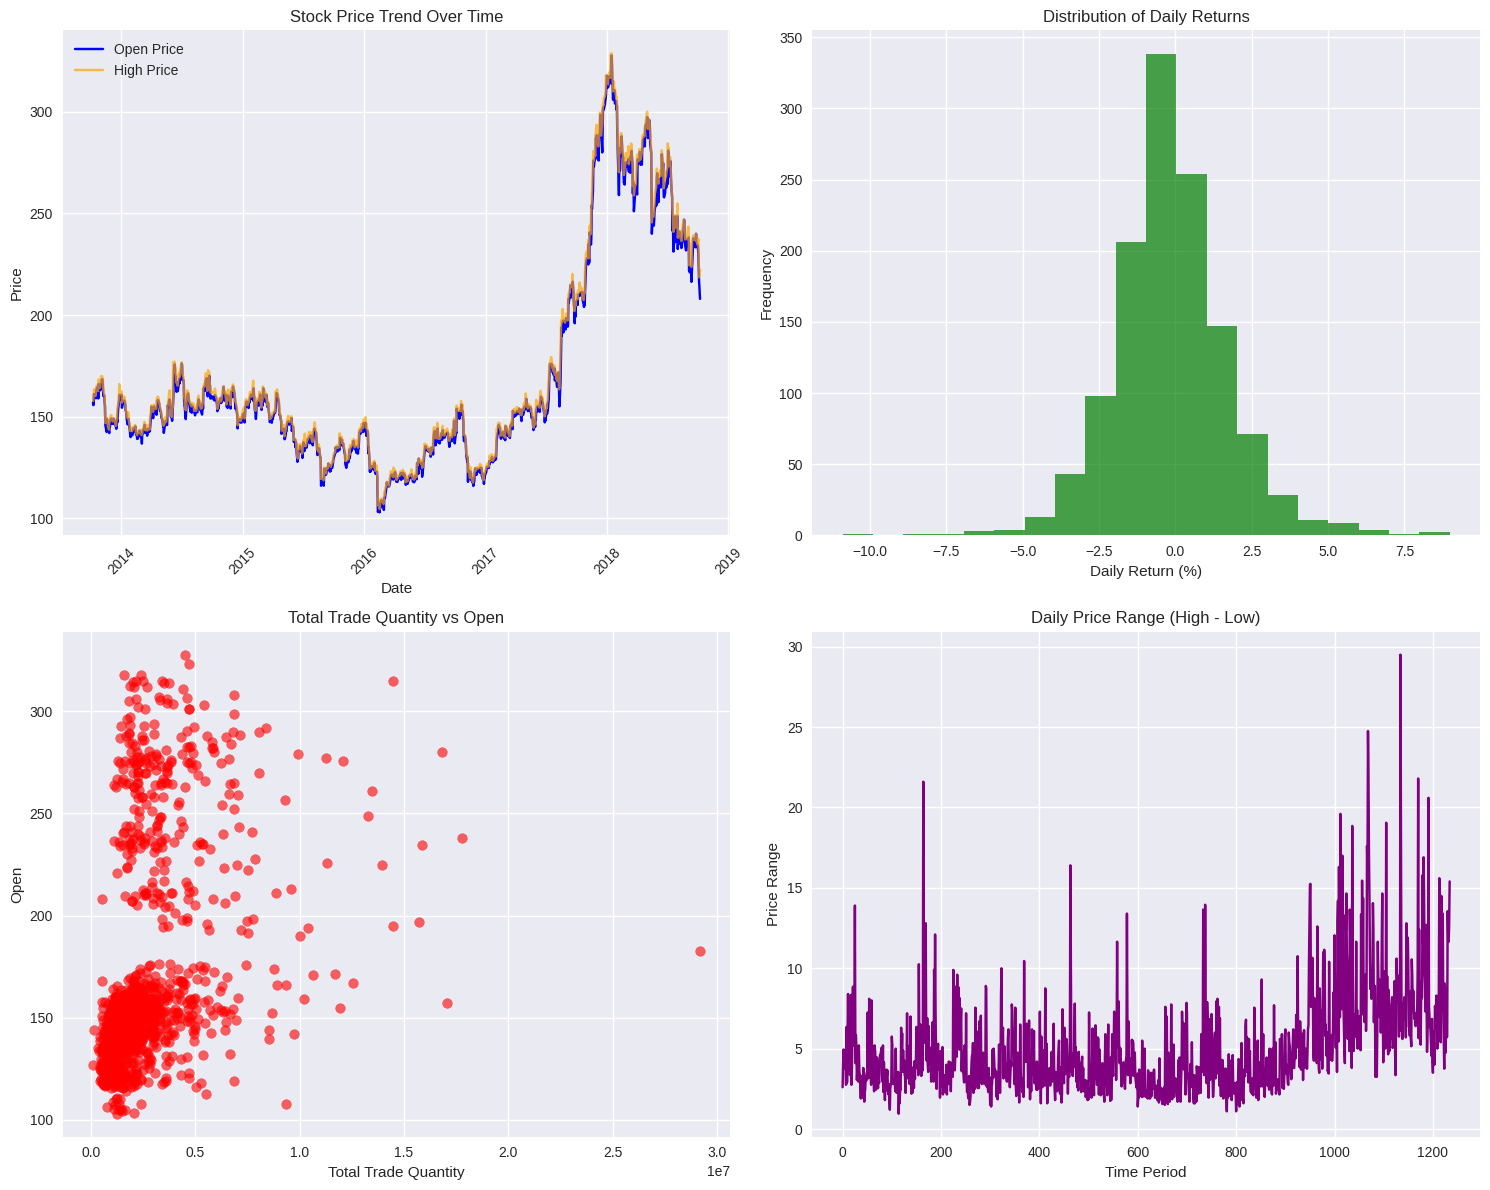

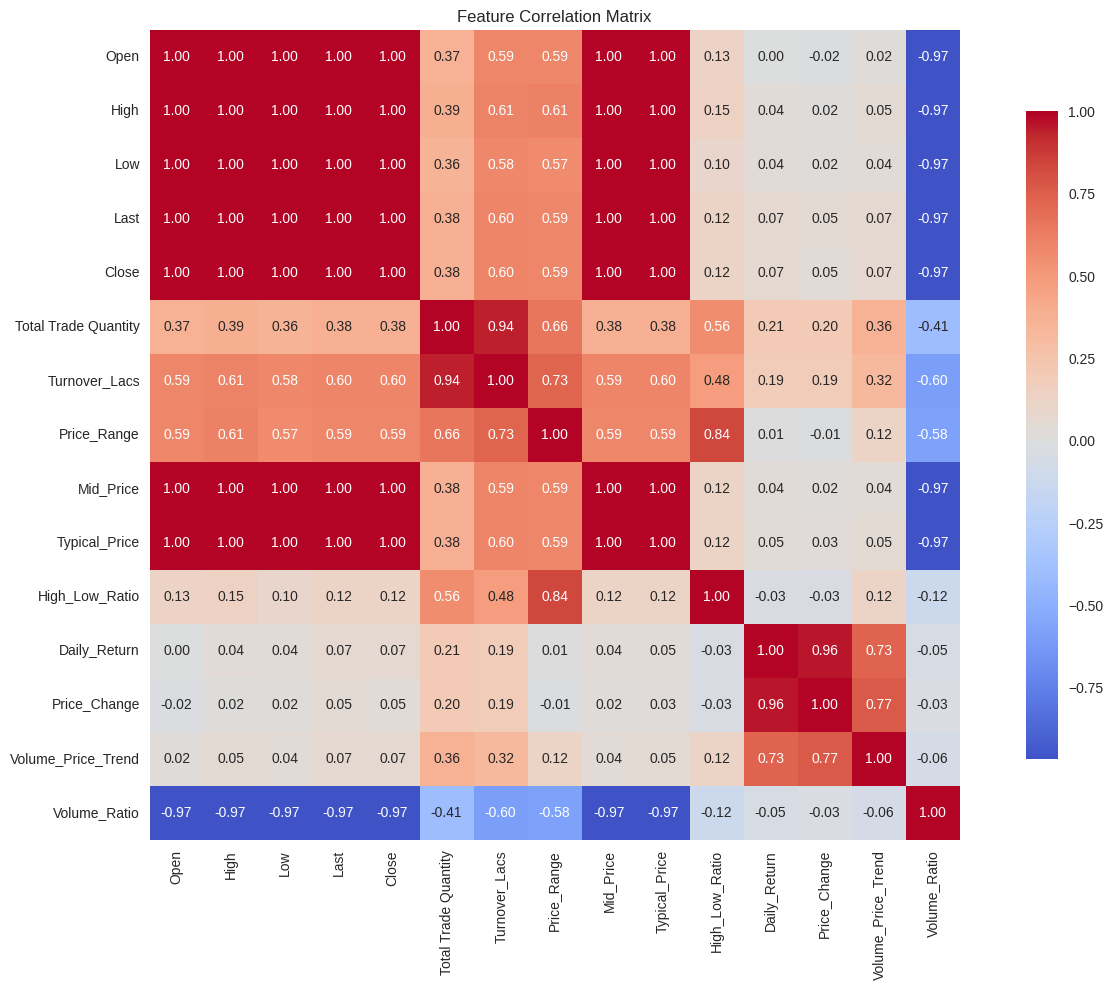

In [14]:
# Step 5: Exploratory Data Analysis (EDA)
# =======================================
print("\n" + "="*50)
print(" EXPLORATORY DATA ANALYSIS")
print("="*50)

# Set up the plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Find suitable columns for plotting
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
price_cols = [col for col in numeric_cols if any(keyword in col.lower()
              for keyword in ['close', 'open', 'high', 'low', 'last', 'price'])]

# Price trend over time
if 'Date' in df_features.columns and len(price_cols) > 0:
    main_price_col = price_cols[0]  # Use first available price column
    axes[0,0].plot(df_features['Date'], df_features[main_price_col], label=f'{main_price_col} Price', color='blue')

    if len(price_cols) > 1:
        second_price_col = price_cols[1]
        axes[0,0].plot(df_features['Date'], df_features[second_price_col],
                      label=f'{second_price_col} Price', color='orange', alpha=0.7)

    axes[0,0].set_title('Stock Price Trend Over Time')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Price')
    axes[0,0].legend()
    axes[0,0].tick_params(axis='x', rotation=45)

elif len(price_cols) > 0:
    main_price_col = price_cols[0]
    axes[0,0].plot(df_features[main_price_col], label=f'{main_price_col} Price', color='blue')

    if len(price_cols) > 1:
        second_price_col = price_cols[1]
        axes[0,0].plot(df_features[second_price_col],
                      label=f'{second_price_col} Price', color='orange', alpha=0.7)

    axes[0,0].set_title('Stock Price Trend')
    axes[0,0].set_xlabel('Time Period')
    axes[0,0].set_ylabel('Price')
    axes[0,0].legend()
else:
    # Plot first two numeric columns if no price columns found
    if len(numeric_cols) >= 2:
        axes[0,0].plot(df_features[numeric_cols[0]], label=numeric_cols[0], color='blue')
        axes[0,0].plot(df_features[numeric_cols[1]], label=numeric_cols[1], color='orange', alpha=0.7)
        axes[0,0].set_title('Data Trend')
        axes[0,0].set_xlabel('Time Period')
        axes[0,0].set_ylabel('Values')
        axes[0,0].legend()

# Distribution of returns or main numeric variable
if 'Daily_Return' in df_features.columns:
    axes[0,1].hist(df_features['Daily_Return'].dropna(), bins=20, alpha=0.7, color='green')
    axes[0,1].set_title('Distribution of Daily Returns')
    axes[0,1].set_xlabel('Daily Return (%)')
    axes[0,1].set_ylabel('Frequency')
elif len(numeric_cols) > 0:
    main_col = numeric_cols[0]
    axes[0,1].hist(df_features[main_col].dropna(), bins=20, alpha=0.7, color='green')
    axes[0,1].set_title(f'Distribution of {main_col}')
    axes[0,1].set_xlabel(main_col)
    axes[0,1].set_ylabel('Frequency')

# Volume vs Price relationship (if available)
volume_cols = [col for col in numeric_cols if any(keyword in col.lower()
               for keyword in ['volume', 'total', 'trd', 'turnover'])]

if len(volume_cols) > 0 and len(price_cols) > 0:
    vol_col = volume_cols[0]
    price_col = price_cols[0]
    axes[1,0].scatter(df_features[vol_col], df_features[price_col], alpha=0.6, color='red')
    axes[1,0].set_title(f'{vol_col} vs {price_col}')
    axes[1,0].set_xlabel(vol_col)
    axes[1,0].set_ylabel(price_col)
elif len(numeric_cols) >= 2:
    axes[1,0].scatter(df_features[numeric_cols[0]], df_features[numeric_cols[1]], alpha=0.6, color='red')
    axes[1,0].set_title(f'{numeric_cols[0]} vs {numeric_cols[1]}')
    axes[1,0].set_xlabel(numeric_cols[0])
    axes[1,0].set_ylabel(numeric_cols[1])

# Price range or variance plot
if 'Price_Range' in df_features.columns:
    axes[1,1].plot(df_features['Price_Range'], color='purple')
    axes[1,1].set_title('Daily Price Range (High - Low)')
    axes[1,1].set_xlabel('Time Period')
    axes[1,1].set_ylabel('Price Range')
elif len(numeric_cols) > 2:
    axes[1,1].plot(df_features[numeric_cols[2]], color='purple')
    axes[1,1].set_title(f'{numeric_cols[2]} Over Time')
    axes[1,1].set_xlabel('Time Period')
    axes[1,1].set_ylabel(numeric_cols[2])

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(14, 10))
# Select numeric columns for correlation (limit to reasonable number)
numeric_cols_for_corr = df_features.select_dtypes(include=[np.number]).columns[:15]  # Limit to 15 columns
correlation_matrix = df_features[numeric_cols_for_corr].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [15]:
# Step 6: Data Preparation for ML Models
# ======================================
print("\n" + "="*50)
print(" DATA PREPARATION FOR ML MODELS")
print("="*50)

# Prepare features and target
# Remove non-numeric and non-predictive columns
columns_to_drop = []
if 'Date' in df_features.columns:
    columns_to_drop.append('Date')

df_ml = df_features.drop(columns=columns_to_drop, errors='ignore')

# Remove rows with NaN values (from lag features)
df_ml = df_ml.dropna().reset_index(drop=True)

print(f" ML Dataset shape after cleaning: {df_ml.shape}")

# Define target variable - try to find the best target column
target_options = ['Close', 'Last', 'close', 'last']
target = None

for opt in target_options:
    if opt in df_ml.columns:
        target = opt
        break

# If no standard target found, use the first numeric column that looks like a price
if target is None:
    numeric_cols = df_ml.select_dtypes(include=[np.number]).columns.tolist()
    price_like_cols = [col for col in numeric_cols if any(keyword in col.lower()
                      for keyword in ['price', 'close', 'last', 'value'])]

    if price_like_cols:
        target = price_like_cols[0]
    else:
        # Use the first numeric column as target
        target = numeric_cols[0]

print(f" Target variable selected: {target}")

# Ensure target exists
if target not in df_ml.columns:
    print(" Error: No suitable target variable found!")
    print(f"Available columns: {list(df_ml.columns)}")
    exit()

features = [col for col in df_ml.columns if col != target]

X = df_ml[features]
y = df_ml[target]

print(f" Number of features: {len(features)}")
print(f" Features: {features[:10]}..." if len(features) > 10 else f" Features: {features}")

# Ensure we have enough data
if len(df_ml) < 10:
    print(" Warning: Very limited data available. Results may not be reliable.")

# Split the data
test_size = min(0.2, max(0.1, 5/len(df_ml)))  # Adaptive test size based on data amount
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, shuffle=False  # Don't shuffle for time series
)

print(f" Data split completed:")
print(f"    Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")

# Feature scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

print("Feature scaling completed")


 DATA PREPARATION FOR ML MODELS
 ML Dataset shape after cleaning: (1230, 34)
 Target variable selected: Close
 Number of features: 33
 Features: ['Open', 'High', 'Low', 'Last', 'Total Trade Quantity', 'Turnover_Lacs', 'Price_Range', 'Mid_Price', 'Typical_Price', 'High_Low_Ratio']...
 Data split completed:
    Training set: (1107, 33)
   Test set: (123, 33)
Feature scaling completed


In [16]:
# Step 7: Model Training and Evaluation
# =====================================
print("\n" + "="*50)
print(" MODEL TRAINING & EVALUATION")
print("="*50)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=100, gamma=0.1),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# Dictionary to store results
results = {}
predictions = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n Training {name}...")

    # Train model
    if name in ['Support Vector Regression', 'Neural Network']:
        # Use scaled data for models that are sensitive to feature scale
        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    else:
        # Use original data for tree-based models
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }

    predictions[name] = y_pred

    print(f" {name} completed")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    R²: {r2:.4f}")



 MODEL TRAINING & EVALUATION

 Training Linear Regression...
 Linear Regression completed
    RMSE: 0.0000
    R²: 1.0000

 Training Ridge Regression...
 Ridge Regression completed
    RMSE: 0.0027
    R²: 1.0000

 Training Lasso Regression...
 Lasso Regression completed
    RMSE: 1.0474
    R²: 0.9976

 Training Random Forest...
 Random Forest completed
    RMSE: 2.5283
    R²: 0.9863

 Training Gradient Boosting...
 Gradient Boosting completed
    RMSE: 5.1263
    R²: 0.9435

 Training Support Vector Regression...
 Support Vector Regression completed
    RMSE: 19.9568
    R²: 0.1441

 Training Neural Network...
 Neural Network completed
    RMSE: 4.7780
    R²: 0.9509



 MODEL COMPARISON RESULTS
 Model Performance Comparison:
                                MSE     RMSE      MAE      R²    MAPE
Linear Regression            0.0000   0.0000   0.0000  1.0000  0.0000
Ridge Regression             0.0000   0.0027   0.0020  1.0000  0.0008
Lasso Regression             1.0970   1.0474   0.8671  0.9976  0.3441
Random Forest                6.3925   2.5283   1.7758  0.9863  0.7266
Gradient Boosting           26.2787   5.1263   3.7497  0.9435  1.5546
Support Vector Regression  398.2746  19.9568  15.6304  0.1441  6.2029
Neural Network              22.8291   4.7780   3.7542  0.9509  1.5050

 Best Model: Linear Regression
    R² Score: 1.0000
    RMSE: 0.0000


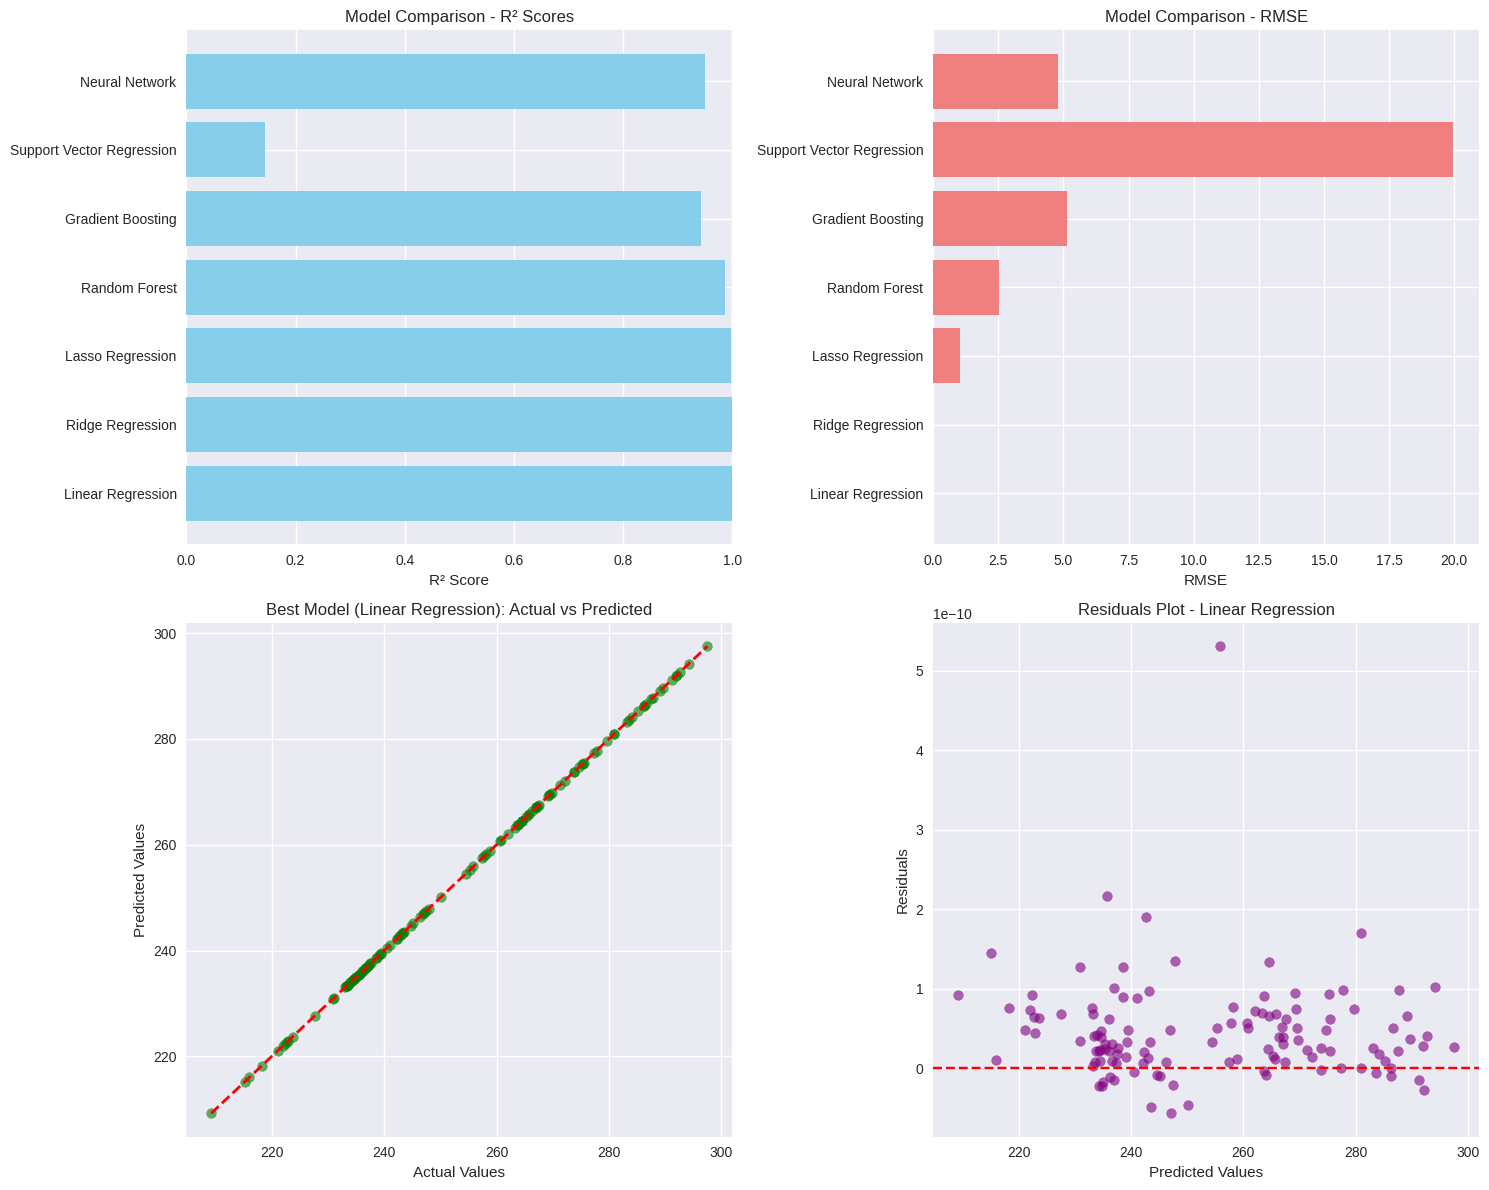

In [17]:
# Step 8: Results Comparison and Visualization
# ===========================================
print("\n" + "="*50)
print(" MODEL COMPARISON RESULTS")
print("="*50)

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print(" Model Performance Comparison:")
print(results_df)

# Find best model
best_model_name = results_df['R²'].idxmax()
print(f"\n Best Model: {best_model_name}")
print(f"    R² Score: {results_df.loc[best_model_name, 'R²']:.4f}")
print(f"    RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f}")

# Visualization of results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Model comparison - R² scores
model_names = list(results.keys())
r2_scores = [results[model]['R²'] for model in model_names]

axes[0,0].barh(model_names, r2_scores, color='skyblue')
axes[0,0].set_xlabel('R² Score')
axes[0,0].set_title('Model Comparison - R² Scores')
axes[0,0].set_xlim(0, 1)

# Model comparison - RMSE
rmse_scores = [results[model]['RMSE'] for model in model_names]
axes[0,1].barh(model_names, rmse_scores, color='lightcoral')
axes[0,1].set_xlabel('RMSE')
axes[0,1].set_title('Model Comparison - RMSE')

# Best model predictions vs actual
best_predictions = predictions[best_model_name]
axes[1,0].scatter(y_test, best_predictions, alpha=0.6, color='green')
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Values')
axes[1,0].set_ylabel('Predicted Values')
axes[1,0].set_title(f'Best Model ({best_model_name}): Actual vs Predicted')

# Residuals plot for best model
residuals = y_test - best_predictions
axes[1,1].scatter(best_predictions, residuals, alpha=0.6, color='purple')
axes[1,1].axhline(y=0, color='red', linestyle='--')
axes[1,1].set_xlabel('Predicted Values')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title(f'Residuals Plot - {best_model_name}')

plt.tight_layout()
plt.show()

In [18]:
# Step 9: Feature Importance Analysis
# ===================================
print("\n" + "="*50)
print(" FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importance from tree-based models
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    best_model = models[best_model_name]
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(" Top 10 Most Important Features:")
    print(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


 FEATURE IMPORTANCE ANALYSIS


In [19]:
# Step 10: Cross-Validation and Model Validation
# ==============================================
print("\n" + "="*50)
print(" CROSS-VALIDATION ANALYSIS")
print("="*50)

# Perform cross-validation for top 3 models
top_3_models = results_df.nlargest(3, 'R²').index.tolist()

cv_results = {}
for model_name in top_3_models:
    model = models[model_name]

    if model_name in ['Support Vector Regression', 'Neural Network']:
        cv_scores = cross_val_score(model, X_train_scaled, y_train_scaled,
                                  cv=5, scoring='r2', n_jobs=-1)
    else:
        cv_scores = cross_val_score(model, X_train, y_train,
                                  cv=5, scoring='r2', n_jobs=-1)

    cv_results[model_name] = {
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'CV_Scores': cv_scores
    }

    print(f" {model_name}:")
    print(f"   Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


 CROSS-VALIDATION ANALYSIS
 Linear Regression:
   Mean CV R²: 1.0000 (+/- 0.0000)
 Ridge Regression:
   Mean CV R²: 1.0000 (+/- 0.0000)
 Lasso Regression:
   Mean CV R²: 0.9867 (+/- 0.0436)


In [20]:
# Step 11: Hyperparameter Tuning for Best Model
# =============================================
print("\n" + "="*50)
print(" HYPERPARAMETER TUNING")
print("="*50)

# Hyperparameter tuning for the best performing model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    print(" Performing Grid Search for Random Forest...")
    grid_search.fit(X_train, y_train)

    print(f" Best parameters: {grid_search.best_params_}")
    print(f" Best CV score: {grid_search.best_score_:.4f}")

    # Evaluate tuned model
    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test)

    tuned_r2 = r2_score(y_test, y_pred_tuned)
    tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

    print(f" Tuned model performance:")
    print(f"   R²: {tuned_r2:.4f}")
    print(f"   RMSE: {tuned_rmse:.4f}")


 HYPERPARAMETER TUNING



 FINAL SUMMARY
 Project Summary:
    Dataset size: 1235 records
    Features created: 33
    Models tested: 7
    Best model: Linear Regression
    Best R² score: 1.0000
    Best RMSE: 0.0000

 Key Insights:
    Excellent model performance (R² > 0.8)

✅ Project completed successfully!
 Results saved to 'model_comparison_results.csv'


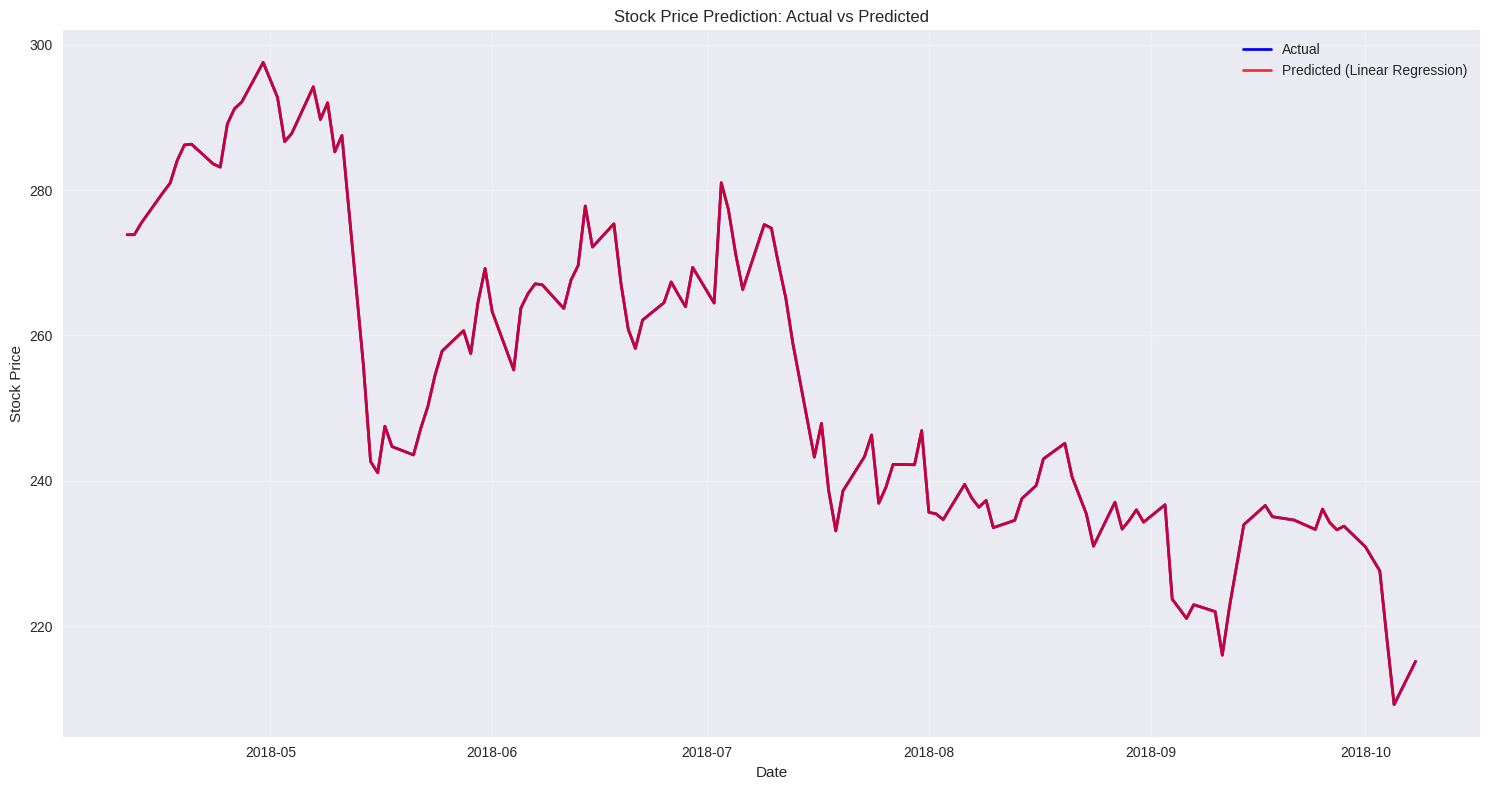


🎉 Stock Price Prediction ML Project Complete! 🎉


In [24]:


# Step 12: Final Model Summary
# ===============================================
print("\n" + "="*50)
print(" FINAL SUMMARY" )
print("="*50)

print(" Project Summary:")
print(f"    Dataset size: {df.shape[0]} records")
print(f"    Features created: {len(features)}")
print(f"    Models tested: {len(models)}")
print(f"    Best model: {best_model_name}")
print(f"    Best R² score: {results_df.loc[best_model_name, 'R²']:.4f}")
print(f"    Best RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f}")

print("\n Key Insights:")
if results_df.loc[best_model_name, 'R²'] > 0.8:
    print("    Excellent model performance (R² > 0.8)")
elif results_df.loc[best_model_name, 'R²'] > 0.6:
    print("    Good model performance (R² > 0.6)")
else:
    print("    Model performance could be improved")



print("\n✅ Project completed successfully!")



# Save results to CSV (optional)
results_df.to_csv('model_comparison_results.csv')
print(" Results saved to 'model_comparison_results.csv'")

# Final visualization: Time series prediction
plt.figure(figsize=(15, 8))
if 'Date' in df_features.columns:
    test_dates = df_features['Date'].iloc[-len(y_test):].values
    plt.plot(test_dates, y_test.values, label='Actual', color='blue', linewidth=2)
    plt.plot(test_dates, best_predictions, label=f'Predicted ({best_model_name})',
             color='red', linewidth=2, alpha=0.8)
    plt.xlabel('Date')
else:
    plt.plot(range(len(y_test)), y_test.values, label='Actual', color='blue', linewidth=2)
    plt.plot(range(len(y_test)), best_predictions, label=f'Predicted ({best_model_name})',
             color='red', linewidth=2, alpha=0.8)
    plt.xlabel('Time Period')

plt.ylabel('Stock Price')
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🎉 Stock Price Prediction ML Project Complete! 🎉")